electricity.csv데이터 기간이 좀 짧은거 같아서 공백 없는 더 긴  데이터 찾아 다시 예측 

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
path = 'data/google.csv'

data = pd.read_csv(path)

In [4]:
data #구글주식

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
1,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
3,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
4,2004-08-26,2.626376,2.701451,2.619119,2.700450,2.700450,141897960
...,...,...,...,...,...,...,...
4512,2022-07-25,108.410004,109.870003,106.300003,107.510002,107.510002,34690900
4513,2022-07-26,106.599998,107.199997,104.070000,105.019997,105.019997,47991000
4514,2022-07-27,109.260002,113.910004,108.010002,113.059998,113.059998,59858500
4515,2022-07-28,112.370003,114.339996,111.459999,114.220001,114.220001,32816600


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4517 non-null   object 
 1   Open       4517 non-null   float64
 2   High       4517 non-null   float64
 3   Low        4517 non-null   float64
 4   Close      4517 non-null   float64
 5   Adj Close  4517 non-null   float64
 6   Volume     4517 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 247.1+ KB


In [25]:


df = data[['Date', 'Close']] #두 변수만 남김

df = df.rename(columns = {
    'Date':'dates',
    'Close':'y'
})

df['dates'] = pd.to_datetime(df['dates'])

df = df.set_index('dates', drop=True)

df

,y
dates,
2004-08-20,2.710460
2004-08-23,2.737738
2004-08-24,2.624374
2004-08-25,2.652653
2004-08-26,2.700450
...,...
2022-07-25,107.510002
2022-07-26,105.019997
2022-07-27,113.059998


<AxesSubplot:title={'center':'Google Close'}, xlabel='dates'>

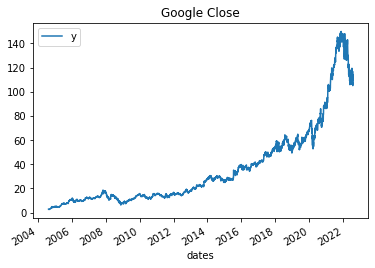

In [26]:
df.plot(title='Google Close')

추세?

In [27]:
df.info() #null없음

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4517 entries, 2004-08-20 to 2022-07-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       4517 non-null   float64
dtypes: float64(1)
memory usage: 70.6 KB


In [28]:
me = df.copy(deep=True) #복사

In [29]:
print('< Input >')
print(me) #데이터 확인

< Input >
                     y
dates                 
2004-08-20    2.710460
2004-08-23    2.737738
2004-08-24    2.624374
2004-08-25    2.652653
2004-08-26    2.700450
...                ...
2022-07-25  107.510002
2022-07-26  105.019997
2022-07-27  113.059998
2022-07-28  114.220001
2022-07-29  116.320000

[4517 rows x 1 columns]


In [30]:
split = int(0.3*len(me)) #7:3 비율

train = me[split:] #학습
test = me[:split] #예측

print('train len :', len(train), ', test len :', len(test))

train len : 3162 , test len : 1355


In [31]:
## adf 검정 ; pvalue 확인 함수
def adf_test(train):
    stat, p_value, lags, nobs, crit, icb = adfuller(train)
    return p_value

In [32]:
p_v = adf_test(train = train)
print('.....original pvalue :', p_v)

.....original pvalue : 0.9785332308577593


In [33]:
## 정상성 확인 및 변환 함수
def stationary(p_v, train):
    
    d = 0
    plot_acf(train, title='Train')
    
    if p_v > 0.05:
        kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
        adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
        d = max(adf_diffs, kpss_diffs)
        print('.....n_diffs :', d)
        
        
        diff1_train = train.diff(d)
        diff1_train = diff1_train.dropna(axis=0)
        a = adf_test(diff1_train)
        
        plot_acf(diff1_train, title='Diff1 Train')
        plot_pacf(diff1_train, title='p Diff1 Train')
        
        if adf_test(diff1_train) >0.05:
            diff1_log2_train = np.log(diff1_train)
            diff1_log2_train = diff1_log2_train.dropna(axis=0)
            a = adf_test(diff1_log2_train)
            plot_acf(diff1_log2_train, title='Diff1 Log2 Train')
            plot_pacf(diff1_log2_train, lags=11, title='p Diff1 Log2 Train')
            
                  
        log1_train = np.log(train)
        log1_train = log1_train.dropna(axis=0)
        b = adf_test(log1_train)
        plot_acf(log1_train, title='Log1 Train')
        plot_pacf(log1_train, title='p Log1 Train')
        # log1_train = log1_train.dropna(axis=0)
        if adf_test(log1_train) >0.05:
            log1_diff2_train = log1_train.diff(d)
            log1_diff2_train = log1_diff2_train.dropna(axis=0)
            b = adf_test(log1_diff2_train)
            plot_acf(log1_diff2_train, title='Log1 Diff2 Train')
            plot_pacf(log1_diff2_train, title='p Log1 Diff2 Train')
            
        print('과연과연', a, b, sep='\n')
            
        
    else:
        print('Already Stationary data')
    
    
    return [d, train]

.....n_diffs : 1


C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


과연과연
3.491462599461574e-20
0.0


C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


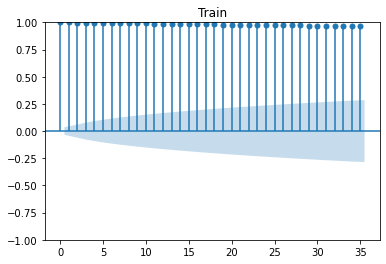

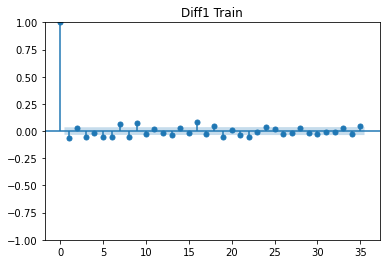

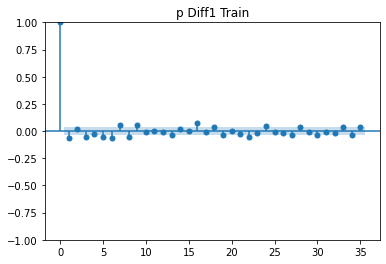

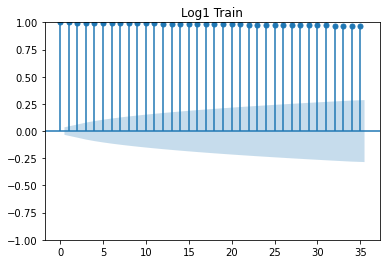

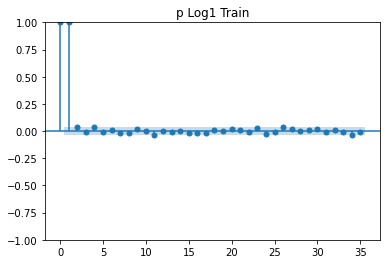

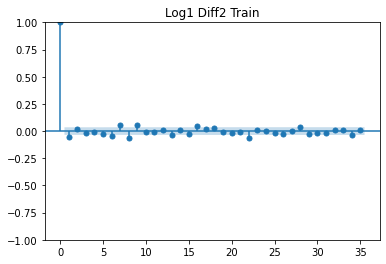

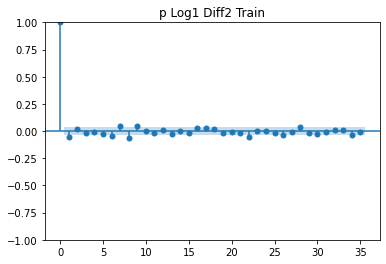

In [34]:
diff, st_train = stationary(p_v=p_v, train = train)

In [35]:
## 최적 모델 찾기

def autoarima(train, diff, m52):

    m_list = [1, 7, 12] #계절성 주기
    if m52 == 'o':
        m_list.append(52)
    
    model = None #모델
    aic = 99999 #AIC
    cycle = 1 #계절성 주기
    
    for m_test in m_list: #52까지 하면 꺼짐
        arima = auto_arima(
                y = train, 
                d = diff, #차분 횟수
                m = m_test, 
                seasonal = True, 
                trace = True
                )
        if arima.aic() < aic:
            aic = arima.aic()
            model = arima
            cycle = m_test
            
    return [cycle, model]

In [36]:
print('< AutoArima >')
cycle, model = autoarima(
                train = train, 
                diff = diff,
                m52 = 'x'
               ) #계절성 주기와 모델 저장

< AutoArima >
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9339.289, Time=2.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9359.400, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9346.787, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9347.342, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9360.282, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9346.327, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9346.330, Time=1.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9334.988, Time=3.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9333.515, Time=1.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9338.363, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=9339.210, Time=2.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9348.252, Time=0.42 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=9339.548, Time=0.55 sec
 ARIMA(2,1,4)(0,0,0)[0] 

In [37]:
print('< Auto Arima Model >', model, sep = '\n')

< Auto Arima Model >
 ARIMA(3,1,1)(2,0,2)[7] intercept


In [38]:
if cycle == 1:
    
    arima = ARIMA(train, order = model.order)
    
else:
    
    arima = SARIMAX(train, order = model.order, seasonal_order = model.seasonal_order)

C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
arima_fit = arima.fit()
print('< ARIMA fit summary >')
print(arima_fit.summary())

C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


< ARIMA fit summary >
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 3162
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -4631.396
Date:                                Thu, 09 Feb 2023   AIC                           9280.791
Time:                                        19:09:15   BIC                           9335.319
Sample:                                             0   HQIC                          9300.353
                                               - 3162                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7107      0.044     16.337      0.000      

< Diagnostic plots for standardized residuals >
Figure(1152x648)


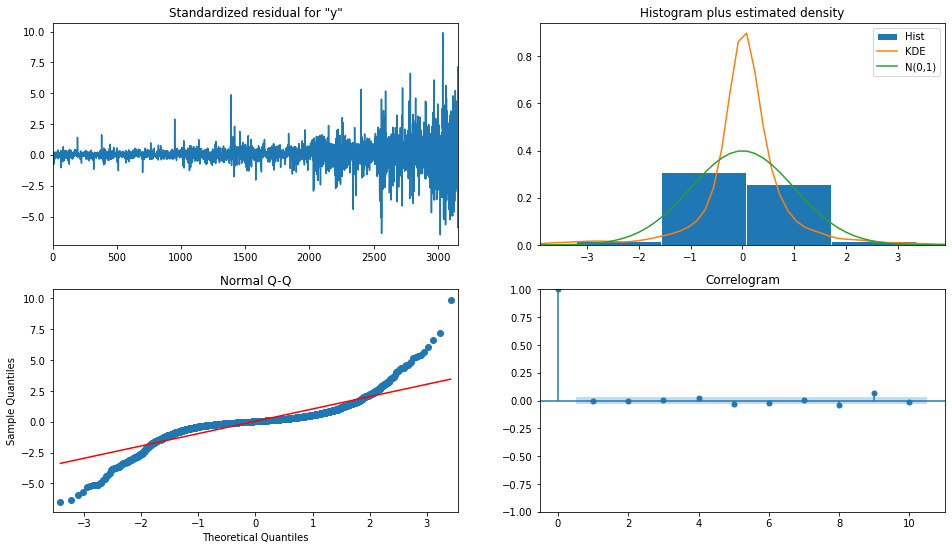

In [40]:
print('< Diagnostic plots for standardized residuals >')
print(arima_fit.plot_diagnostics(figsize = (16,9)))

In [41]:
future_forecast = arima_fit.predict(
                        start = test.index[0],
                        end = test.index[-1],
                        typ='levels'
                  )

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
plt.plot(me, label='Original data')
plt.plot(future_forecast, label='ARIMA model')

plt.legend()
plt.show()